# Neural Cellular Automata

Les automates cellulaires sont des modèles mathématiques discrets utilisés pour simuler des systèmes complexes à travers des interactions locales simples entre cellules. Dans le contexte de la génération de textures, ces automates peuvent produire des motifs visuellement intéressants et variés. Cependant, la conception des règles d'évolution de ces automates peut s'avérer délicate et laborieuse.

Pour surmonter cette difficulté, l'utilisation de réseaux de neurones pour définir les règles d'évolution des automates cellulaires s'avère être une approche innovante et prometteuse. Les réseaux de neurones, grâce à leur capacité d'apprentissage et de généralisation, peuvent être entraînés pour identifier et appliquer des règles d'évolution complexes à partir de données d'entraînement.

#### papers:

[1] Alexander Mordvintsev and Eyvind Niklasson. µNCA: Texture generation with ultra-compact
neural cellular automata. ArXiv, abs/2111.13545, 2021.

[2] Mordvintsev A, Niklasson E, Randazzo E (2021) Texture generation with neural cellular automata. arXiv:2105.07299


### fonctions auxiliaires

In [16]:
import torch
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import mse_loss

# Utilities
# Functions to manage images

MEAN = (0.485, 0.456, 0.406)   # moyenne sur chaque channel des images du dataset IMAGENET

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py


def gramm(tnsr: torch.Tensor) -> torch.Tensor:
    """Computes Gram matrix for the input batch tensor.

    Args:
        tnsr (torch.Tensor): batch input tensor of shape [B, C, H, W].


    Returns:
        G (torch.Tensor): batch of gramm matrices of shape [B, C, C].
    """
    b, c, h, w = tnsr.size()
    F = tnsr.view(b, c, h * w)
    G = torch.bmm(F, F.transpose(1, 2))
    G.div_(h * w)
    return G


def gram_loss(input: torch.Tensor, gramm_target: torch.Tensor, weight: float = 1.0):
    """
    Computes MSE Loss for 2 Gram matrices input and target.

    Args:
        input (torch.Tensor): input tensor of shape [B, C, H, W].
        gramm_target (torch.Tensor): target tensor of shape [B, C, C].
        weight (float): weight for the loss. Default: 1.0.

    """
    return weight * mse_loss(gramm(input), gramm_target)


def prep_img_file(image: str, size=None, mean=MEAN):
    """Preprocess image.
    1) load as PIl
    2) resize
    3) convert to tensor
    5) remove alpha channel if any
    """
    im = Image.open(image)
    texture = resize(im, size)
    tensor = to_tensor(texture).unsqueeze(0)
    if tensor.shape[1] == 4:
        # print("removing alpha chanel")
        tensor = tensor[:, :3, :, :]
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(
        -1, 1, 1
    )

    tensor.sub_(mean)
    return tensor


def prep_img_tensor(tensor: torch.Tensor, size=None, mean=MEAN):
    """Preprocess image tensor.
    1) resize
    2) subtract mean and multiply by 255
    """

    # Resize the image tensor if size is specified
    if size is not None:
        tensor = resize(tensor, size).unsqueeze(0)

    # Handle RGB images
    if tensor.shape[1] == 3:
        pass
        # print('Image is RGB.')
    elif tensor.shape[1] == 1:
        print("Converting grayscale image to RGB.")
        tensor = torch.cat([tensor] * 3, dim=1)

    # Substract mean and multiply by 255
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(
        -1, 1, 1
    )
    tensor.sub_(mean)  # .mul_(255)

    return tensor


# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py


def denormalize(tensor: torch.Tensor, mean=MEAN):

    tensor = tensor.clone().squeeze()
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(
        -1, 1, 1
    )
    tensor.mul_(1.0 / 255).add_(mean)
    return tensor


# Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py


def to_pil(img):
    """Converts centered tensor to PIL Image.
    Args: tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
    Returns: PIL Image: converted img.
    """

    img = to_pil_image(img)
    return img


def to_img(tensor):
    t1 = tensor[0][:3].T.cpu().detach().numpy()
    t1 += MEAN
    t1 = t1.clip(0, 1)
    return np.transpose(t1, axes=(1, 0, 2))


### Définitions

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import datetime
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)


### architecture

L'architecture du réseau se compose de trois couches de convolution :

- La première série de convolutions est fixée et correspond aux dérivées partielles et au laplacien de chaque canal.
- Les deuxième et troisième couches sont des convolutions 1x1, ce qui équivaut à avoir une couche entièrement connectée (fully connected) appliquée indépendamment à chaque pixel.

![alt text](../ressources/neuralCA/architecture.png "architecture")

In [18]:

class RecursiveNN(nn.Module):
    def __init__(
        self,
        loss,
        img_size=128,
        img_layer_depth=12,
        cpool_size=1024,
        learning_rate=2e-4,
        bach_size=4,
    ):
        super(RecursiveNN, self).__init__()

        self.loss = loss
        self.img_size = img_size
        self.img_layer_depth = img_layer_depth
        self.cpool_size = cpool_size
        self.learning_rate = learning_rate
        self.bach_size = bach_size

        self.ident = torch.tensor(
            [[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]
        ).to(device)
        self.sobel_x = torch.tensor(
            [[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]
        ).to(device)
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).to(
            device
        )

        self.cn1 = nn.Conv2d(
            4 * img_layer_depth, 96, kernel_size=1, padding=0, stride=1
        ).to(device)

        self.cn2 = nn.Conv2d(
            96,
            img_layer_depth,
            kernel_size=1,
            padding=0,
            stride=1,
            bias=False,  # Semble vraiment être important pour éviter la divergence
        ).to(device)

        # self.cn1.weight.data.zero_() Surtout pas, augmente énormément le temps de convergence
        self.cn2.weight.data.zero_()

        # Création de la pool d'images (avec les channels en plus)
        self.cpool = torch.rand(
            size=(self.cpool_size, self.img_layer_depth, self.img_size, self.img_size),
            dtype=torch.float32,
            requires_grad=False,
        ).to(device)

        self.total_training_steps = 0
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        """ "from the paper"""
        b, ch, h, w = x.shape
        filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap]).to(
            device
        )

        y = x.reshape(b * ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1, 1, 1, 1], "circular")
        y = torch.nn.functional.conv2d(y, filters[:, None])
        y = y.reshape(b, -1, h, w)

        """end of paper"""

        out = self.cn2(F.relu(self.cn1(y)))

        return out + x

    def render(self, it, width, height, save=True):

        x = torch.rand(
            size=(1, self.img_layer_depth, width, height), dtype=torch.float32
        ).to(device)
        # remplace un des éléments du batch par du bruit
        with torch.no_grad():
            for _ in range(it):
                x = self(x)

        if save:
            plt.imsave(
                f"output/{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{it}_iterations.png",
                to_img(x),
            )
        return x

    def start_training(self, nb_steps, debug=False, save_on_interrupt=True):

        optim = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.train()  # met le modèle en mode entrainement
        loss_history = []

        # Progress bar
        pbar = tqdm(total=nb_steps)

        try:
            for i in range(nb_steps):

                indices = torch.randint(
                    low=0, high=self.cpool_size, size=(self.bach_size,)
                )
                # print(indices)
                current_batch = self.cpool[indices]

                # remplace une image du batch par du bruit
                current_batch[0] = torch.rand(
                    size=(self.img_layer_depth, self.img_size, self.img_size),
                    dtype=torch.float32,
                    requires_grad=False,
                ).to(device)
                # le clone est nécessaire ? Probablement pas, faut juste remplace le bon dans la pool
                current_batch = current_batch.clone().detach()

                # On applique itérativement le modèle sur l'image
                niter = torch.randint(low=32, high=64, size=(1,))
                for _ in range(niter):
                    current_batch = self(current_batch)

                L = self.loss.compute_loss(current_batch)

                with torch.no_grad():
                    L.backward()
                    for p in self.parameters():
                        p.grad /= p.grad.norm() + 1e-8  # normalize gradients
                    optim.step()
                    optim.zero_grad()

                # On met à jour la pool d'images
                self.cpool[indices] = current_batch.detach()

                pbar.set_description(
                    f"\rstep {i+1} / {nb_steps} | loss: {L.item():.3e} | extremums: [{torch.min(current_batch):.3e}, {torch.max(current_batch):.3e}]"
                )
                loss_history.append(L.item())
                pbar.update()
                self.total_training_steps += 1
            if save_on_interrupt:
                self.save_weights()
        except KeyboardInterrupt:
            print("\ntraining interrupted !")

            if save_on_interrupt:
                self.save_weights()
            quit(1)

        pbar.close()

        # save loss history
        plt.plot(loss_history)
        plt.xlabel("Training Step")
        plt.ylabel("Loss")
        plt.title("Loss History")
        plt.savefig(
            f"loss_history_{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{self.total_training_steps}_steps.png"
        )

    def save_weights(self, dir_path="trained_models") -> None:
        def create_directory_if_not_exists(dir_path):
            if not os.path.exists(dir_path):
                os.mkdir(dir_path)

        create_directory_if_not_exists(dir_path)
        filename = f"model_{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{self.total_training_steps}_steps.pth"
        torch.save(self.state_dict(), f"{dir_path}/{filename}")

    def load_weights(self, path):
        self.load_state_dict(torch.load(path))


### Loss et trainning

Pour la fonction de perte, l'image de sortie est passée à travers un réseau de neurones préalablement entraîné pour la classification d'images, en l'occurrence le réseau VGG formé sur le dataset ImageNet. Nous comparons ensuite les matrices de Gramm des activations du VGG à certaines couches spécifiques. Ces matrices de Gramm capturent les caractéristiques de texture et permettent de mesurer la similarité entre les textures générées et les textures cibles.

![alt text](../ressources/neuralCA/trainning.png "trainning")

In [19]:


class LossClass:
    def __init__(self, reference_image_path, ref_im_size) -> None:
        """
        @param reference_image_path: path to the reference image
        @param ref_im_size: size of the reference image (resized to this size)
        """
        # Initialisation of the VGG19 model
        self.vgg_cnn = models.vgg19(weights="IMAGENET1K_V1").features.to(device)

        self.vgg_cnn.requires_grad_(False)

        # initialise l'extraction des couches pour la loss
        self.extracted_layers_indexes = [1, 6, 11, 20, 29]
        self.layers_weights = [1 / n**2 for n in [64, 128, 256, 512, 512]]

        # Contient la réponse des différentes couches de vgg à l'image de référence
        self.vgg_outputs = {}

        def save_output(name):
            # The hook signature
            def hook(module, module_in, module_out) -> None:
                self.vgg_outputs[name] = module_out

            return hook

        # le handle est useless
        for layer in self.extracted_layers_indexes:
            handle = self.vgg_cnn[layer].register_forward_hook(save_output(layer))

        # Charge l'image de référence et la prépare (resize, normalisation, etc.)
        self.reference_img = prep_img_file(reference_image_path, ref_im_size).to(device)

        # Calcul de la matrice de gramm pour chaque couche
        self.vgg_cnn(self.reference_img / 0.25)
        self.gramm_targets = [
            gramm(self.vgg_outputs[key]) for key in self.extracted_layers_indexes
        ]

    def compute_loss(self, imgs):
        # img : batch de 4 images de taille 12x128x128

        total_loss = torch.tensor(0.0).to(device)

        # Prepare texture data
        synth = []
        for i in range(4):
            synth.append(imgs[i][:3].unsqueeze(0))

        # Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
        for x in synth:
            losses = []
            self.vgg_cnn(x / 0.25)
            synth_outputs = [
                self.vgg_outputs[key] for key in self.extracted_layers_indexes
            ]
            # calcul des loss pour toutes les couches

            for activations in zip(
                synth_outputs, self.gramm_targets, self.layers_weights
            ):
                losses.append(gram_loss(*activations).unsqueeze(0))

            total_loss = total_loss + torch.cat(losses).sum()
        clip_loss = torch.sum(torch.abs(imgs - imgs.clip(-1, 1))) / torch.numel(imgs)
        return total_loss + clip_loss


## utilisation

In [25]:

l = LossClass("../ressources/neuralCA/bubbly_128.jpg", 128)
model = RecursiveNN(l)
model.start_training(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/lpottier/Documents/boulot/Telecom_Paris/PROJ104/synthese-image-2/env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/lpottier/Documents/boulot/Telecom_Paris/PROJ104/synthese-image-2/env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 130.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
step 5 / 1000 | loss: 7.610e-03 | extremums: [-7.720e-01, 1.021e+00]:   0%|          | 5/1000 [00:03<11:31,  1.44it/s]/home/lpot

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

/home/lpottier/Documents/boulot/Telecom_Paris/PROJ104/synthese-image-2/env/lib/python3.10/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)


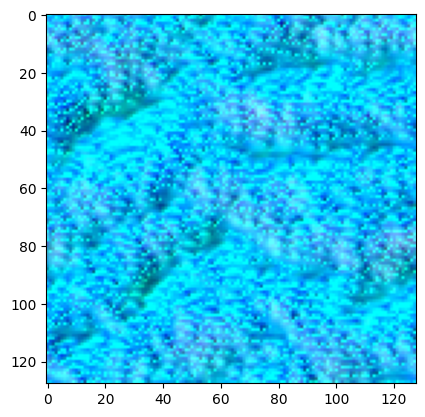

In [24]:
finish = model.render(300, width=128, height=128, save=False)
plt.imshow(to_img(finish))
plt.show()

## resultats

![alt text](../ressources/neuralCA/448589827_1436556910388360_8373742507255964572_n.png "trainning")